<a href="https://colab.research.google.com/github/Malefie/AV-Ecommerce/blob/master/Codes/AVHackathon_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/My Drive/AV-JanataHack/AV-Ecommerce/AV-JanataHack/Files

/content/drive/My Drive/AV-JanataHack/AV-Ecommerce/AV-JanataHack/Files


# Pre-Processing


In [0]:
timebook = {'1day':24*60*60,
           '1hour':60*60,
           '1min':60}

In [0]:
from matplotlib import pyplot as plt
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import datetime as dt

In [0]:
def get_duration(data):
    data.startTime = data['startTime'].apply(lambda x : dt.datetime.strptime(x, "%d/%m/%y %H:%M"))
    data.endTime = data['endTime'].apply(lambda x : dt.datetime.strptime(x, "%d/%m/%y %H:%M"))
    data['duration'] = (data['endTime'] - data['startTime']).apply(lambda x : x.total_seconds())
    data["HourOfDay"] = data.startTime.apply(lambda x: x.hour)
    return data    

In [0]:
def filtering_duration(data):
    data = data[(data.duration > 0) & (data.duration < 8526)]
    return data

In [0]:
def explode_productList(data):
    data['ProductList'] = data['ProductList'].apply(lambda x: x.split(";"))
    data = data.explode('ProductList')
    data[['Category','Sub_Category', 'Sub_Sub_Category', 'Product','extra']] = data.ProductList.str.split("/",expand=True)
    data.drop(labels='extra',axis = 1, inplace=True)
    return data


In [0]:
def prod_cat_counts(data, data_f):
    # data2 = data2[['session_id', 'Category', 'Sub_Category', 'Sub_Sub_Category', 'Product']]
    data_prod_cat_info = data.groupby(['session_id']).agg({'Category':pd.Series.nunique,
     'Sub_Category':pd.Series.nunique,
     'Sub_Sub_Category':pd.Series.nunique,
     'Product':pd.Series.nunique}).rename(columns = {'Category':'cat_count',
                                                     'Sub_Category':'sub_cat_count', 
                                                     'Sub_Sub_Category':'sub_sub_cat_count',
                                                     'Product':'prod_count'}).reset_index()
    print(data_prod_cat_info.columns)
    data2 = pd.merge(data_f, data_prod_cat_info, how='inner', on='session_id')
    return data2

In [0]:
def get_dummies(data, cols_to_dummy):
  data["c_sc"] = data['Category']+data['Sub_Category']
  dummy_df = pd.get_dummies(data["c_sc"])
  data_w_dummy = pd.concat([data['session_id'],dummy_df],axis = 1)
  data_w_dummy_1 = data_w_dummy.groupby('session_id').max().reset_index()
  return data_w_dummy_1

In [0]:
def get_dataset(data):
    df = get_duration(data)
    data = explode_productList(data)
    cols_to_dummy = ['Category','Sub_Category']
    data_dummy = get_dummies(data, cols_to_dummy)
    data = prod_cat_counts(data,df)
    data = pd.merge(data, data_dummy, on='session_id', how='inner')
    return data

In [0]:
train = pd.read_csv('train_8wry4cB.csv')
test = pd.read_csv("test_Yix80N0.csv")
train['dataset'] = 'train'
test['dataset'] = 'test'
train_y = train['gender']
merged_data = pd.concat([train[['session_id', 'startTime', 'endTime', 'ProductList','dataset']], test])

In [17]:
merged_data.dtypes

session_id     object
startTime      object
endTime        object
ProductList    object
dataset        object
dtype: object

In [18]:
merged_data.head(5)

,session_id,startTime,endTime,ProductList,dataset
0,u16159,15/12/14 18:11,15/12/14 18:12,A00002/B00003/C00006/D28435/;A00002/B00003/C00...,train
1,u10253,16/12/14 14:35,16/12/14 14:41,A00001/B00009/C00031/D29404/;A00001/B00009/C00...,train
2,u19037,01/12/14 15:58,01/12/14 15:58,A00002/B00001/C00020/D16944/,train
3,u14556,23/11/14 2:57,23/11/14 3:00,A00002/B00004/C00018/D10284/;A00002/B00004/C00...,train
4,u24295,17/12/14 16:44,17/12/14 16:46,A00001/B00001/C00012/D30805/;A00001/B00001/C00...,train


In [21]:
merged_data = get_dataset(merged_data)

Index(['session_id', 'cat_count', 'sub_cat_count', 'sub_sub_cat_count',
       'prod_count'],
      dtype='object')


In [22]:
merged_data.columns

Index(['session_id', 'startTime', 'endTime', 'ProductList', 'dataset',
       'duration', 'HourOfDay', 'cat_count', 'sub_cat_count',
       'sub_sub_cat_count',
       ...
       'A00010B00076', 'A00010B00082', 'A00010B00083', 'A00010B00085',
       'A00010B00088', 'A00010B00090', 'A00010B00091', 'A00011B00050',
       'A00011B00056', 'A00011B00077'],
      dtype='object', length=102)

In [23]:
merged_data.shape

(15000, 102)

In [0]:
train = merged_data[merged_data['dataset'] == 'train']
test = merged_data[merged_data['dataset'] == 'test']

In [25]:
train['gender'] = train_y
train['gender_flag'] = train_y.apply(lambda x : 0 if x == 'female' else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
train.shape

In [0]:
test.shape

In [0]:
train.to_csv("processed_train.csv")
test.to_csv("processed_test.csv")

# Modelling

In [0]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
train = pd.read_csv('processed_train.csv')
test = pd.read_csv('processed_test.csv')

In [5]:
train.shape, test.shape

((10500, 105), (4500, 103))

In [0]:
def row_type(dur):
  if dur <60:
    return 0
  elif (dur >=60) & (dur <=8526):
    return 1
  else:
    return 2

In [0]:
train['row_type'] = train['duration'].apply(lambda x:row_type(x))
test['row_type'] = test['duration'].apply(lambda x:row_type(x))

In [0]:
train['gender_flag'] = train['gender'].apply(lambda x : 0 if x == 'female' else 1)

In [9]:
train[train.row_type==0]['gender_flag'].value_counts()

0    4283
1    1278
Name: gender_flag, dtype: int64

# Ensemble

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [0]:
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline
import xgboost as xgb

In [0]:
def get_train_set(data):
  Train_Y= data['gender_flag']
  X_cols_to_drop = ['Unnamed: 0','gender_flag','gender','session_id','startTime','endTime','ProductList', 'row_type', 'dataset']
  Train_X = data.drop(labels = X_cols_to_drop ,axis = 1)
  #print (Train_X.columns)
  return Train_X, Train_Y

In [0]:

train_x, train_y = get_train_set(train)
xtrain, xtest, ytrain, ytest = train_test_split(train_x, train_y, test_size=0.3, random_state=0)

In [14]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=5)
    lr = LogisticRegression(C=100, random_state=0)
    nn = MLPClassifier((100, 1),activation= 'logistic',solver='lbfgs',learning_rate='adaptive', max_iter=500, random_state=0)
    gb = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01,random_state=0)
    rf = RandomForestClassifier(n_estimators=500,  criterion='entropy',random_state=0)


    models = {#'svm': svc,
              'knn': knn,
              #'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb
              #'xgb' : xgbc
              #'logistic': lr,
              }

    return models


def train_predict(model_list):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [17]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
knn... done
mlp-nn... done
random forest... done
gbm... done
Done.

Scoring models.
knn                       : 0.739
mlp-nn                    : 0.781
random forest             : 0.821
gbm                       : 0.780
Done.



[MLENS] backend: threading
[MLENS] Found 1 residual cache(s):
        1 (4096): /tmp/.mlens_tmp_cache_h4wdl3md
        Total size: 4096
[MLENS] Removing... done.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


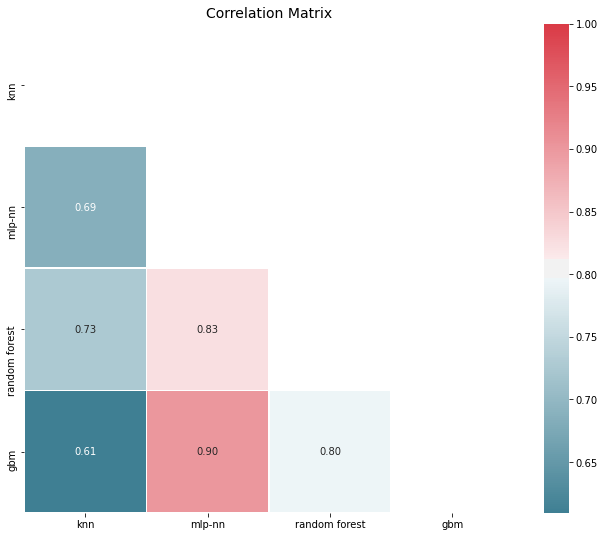

In [18]:
# You need ML-Ensemble for this figure: you can install it with: pip install mlens
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)
plt.show()

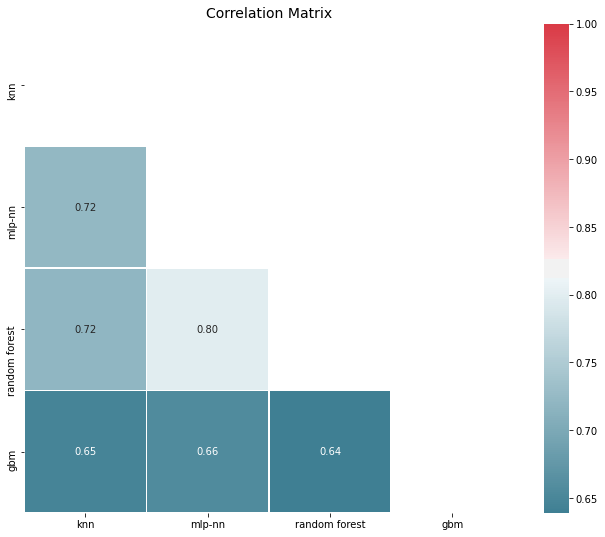

In [19]:
corrmat(P.apply(lambda pred: 1*(pred >= 0.5) - ytest.values).corr(), inflate=False)
plt.show()

In [20]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.818


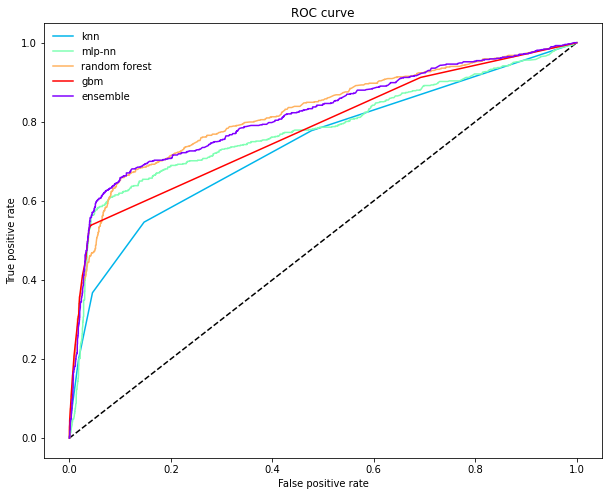

In [21]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
      for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

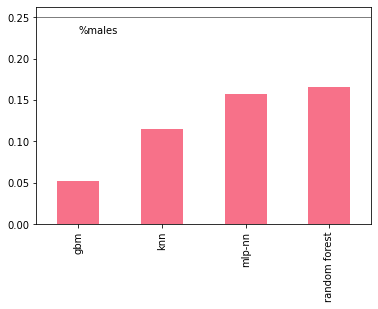

In [22]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["0", "1"]
p.iloc[1, :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "%males")
plt.show()

# Learning to combine predictions

In [0]:
SEED = 0

In [0]:
base_learners = get_models()

In [0]:
meta_learner = GradientBoostingClassifier(
    n_estimators=100,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=SEED)

In [0]:
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(
    xtrain, ytrain, test_size=0.5, random_state=SEED)

In [0]:
def train_base_learners(base_learners, inp, out, verbose=True):
    """
    Train all base learners in the library.
    """
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

In [28]:
train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
knn... done
mlp-nn... done
random forest... done
gbm... done


In [0]:
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """
    Generate a prediction matrix.
    """
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

In [30]:
P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
knn... done
mlp-nn... done
random forest... done
gbm... done


In [31]:
meta_learner.fit(P_base, ypred_base)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=150, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=0.8, verbosity=1)

In [0]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """
    Generate predictions from the ensemble.
    """
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

In [33]:
P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
knn... done
mlp-nn... done
random forest... done
gbm... done

Ensemble ROC-AUC score: 0.809


In [0]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")

    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds)
    cv_y = np.hstack(cv_y)

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [35]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...done
Generating cross-validated predictions...
Fold 1 done
Fold 2 done
CV-predictions done
Fitting meta learner...done

Ensemble ROC-AUC score: 0.810


In [36]:
!pip install mlens

In [0]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=5,
    random_state=SEED,
    verbose=2,
    backend="multiprocessing"
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers
Processing layer-1             done | 00:01:30
Processing layer-2             

In [0]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")

In [82]:
X_cols_to_drop = ['Unnamed: 0','session_id','startTime','endTime','ProductList', 'dataset','row_type']
Test_X = test.drop(labels = X_cols_to_drop ,axis = 1)

gender = sl.predict_proba(Test_X)
gender


Predicting 2 layers
Processing layer-1             done | 00:00:01
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


array([[0.87896264, 0.12103739],
       [0.8752924 , 0.12470756],
       [0.91364515, 0.08635487],
       ...,
       [0.87289095, 0.12710905],
       [0.3124258 , 0.6875742 ],
       [0.8617964 , 0.13820364]], dtype=float32)

In [84]:
gender[:,1]

array([0.12103739, 0.12470756, 0.08635487, ..., 0.12710905, 0.6875742 ,
       0.13820364], dtype=float32)

In [0]:
test['gender'] = gender[:,1]
test['gender'] = test['gender'].apply(lambda x: 'male' if x>=0.5 else 'female')

In [0]:
output = test[['session_id', 'gender']]
output.to_csv('output.csv')

# Old section

In [0]:
def get_train_set(data):
  Train_Y= data['gender_flag']
  X_cols_to_drop = ['Unnamed: 0','gender_flag','gender','session_id','startTime','endTime','ProductList', 'row_type', 'dataset']
  Train_X = data.drop(labels = X_cols_to_drop ,axis = 1)
  #print (Train_X.columns)
  return Train_X, Train_Y

In [0]:
def get_train_test_split(x, y, split):
  
  for train_index, test_index in sss.split(X, y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

  return X_train, X_test, y_train, y_test

In [0]:
def train_model(model, x, y):
    model.fit(x, y)
    return model

In [0]:
def with_split_evaluation(model, X, Y, split=0):
  if split != 0:
    sss = StratifiedShuffleSplit(n_splits=split, test_size=0.3, random_state=0)
    roc_train = []
    roc_test = []
    for train_index, test_index in sss.split(X, Y):
      #print("TRAIN:", train_index, "TEST:", test_index)
      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

      #print(X_train.shape, X_test.shape)
      #print(X_train.dtypes, X_test.dtypes)
      model.fit(X_train, y_train)
      #Train accuracy
      print("Train Accuracy: ", "\n")
      y_trn_pred = model.predict(X_train)
      roc_auc = evaluation_metrics(y_train, y_trn_pred)
      roc_train.append(roc_auc)
      
      #Test accuracy
      y_pred = model.predict(X_test)
      print("CV Accuracy: ", "\n")

      roc_auc = evaluation_metrics( y_test, y_pred)
      roc_test.append(roc_auc)
      
      print("\n")
    print ("Avg. Train Roc-auc: ", np.array(roc_train).mean())
    print ("Avg. Test Roc-auc: ", np.array(roc_test).mean())

  else:
    model.fit( X,Y)
    #Train accuracy
    print("Train Accuracy: ", "\n")
    y_trn_pred = model.predict(X)
    evaluation_metrics(Y, y_trn_pred)
    print("\n")

  return model

In [0]:
def evaluation_metrics( y_test, y_pred):
  print("Accuracy:",accuracy_score( y_test, y_pred))
  print("Precision:",precision_score(y_test, y_pred))
  print("Recall:",recall_score(y_test, y_pred))
  print("F1-score:",f1_score(y_test, y_pred))
  print("rOC-auc:",roc_auc_score(y_test, y_pred))
  return roc_auc_score(y_test, y_pred)

In [0]:
def with_gridsearch_evaluation(model, x,y):
  #start = time()
  model.fit(x, y)
  #elapse = time() - start
  #n_iter_search = len(grid_search.cv_results_['params'])
  #message = 'GridSearchCV took {:.2f} seconds for {} parameter settings'
  #print(message.format(elapse, n_iter_search))
  #report(grid_search)
  for i in range(len(model.cv_results_['params'])):
    print("{} : {}".format(model.cv_results_['params'][i],    model.cv_results_['mean_test_score'][i]))

  print("Params : {} \nScore : {}".format(model.best_params_,model.best_score_))
  print (model.get_params)
  return model

In [0]:

def model_train_all(data, M0, M1, M2, split =5):
  
  #Data for M0
  data0 = data[data['row_type']==0]
  if len(data0) !=0:
    X, Y = get_train_set(data0)
    print("####################################################")
    print(Y.value_counts())
    #model0 = with_split_evaluation(M0, X, Y, split)
    model0 = with_gridsearch_evaluation(M0, X, Y)
    #Print model report:
    predictions = model0.predict(X)
    predict_proba = model0.predict_proba(X)[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(Y, predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(Y, predict_proba))

  # Data for M1
  data1 = data[data['row_type']==1]
  if len(data1) !=0:
    X, Y = get_train_set(data1)
    print("####################################################")
    print(Y.value_counts())
    #model1 = with_split_evaluation(M1, X, Y, split)
    model1 = with_gridsearch_evaluation(M1, X, Y)

    #Print model report:
    predictions = model1.predict(X)
    predict_proba = model1.predict_proba(X)[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(Y, predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(Y, predict_proba))

    

  # Data for M2
  data2 = data[data['row_type']==2]
  if len(data2) !=0:
    X, Y = get_train_set(data2)
    print("####################################################")
    print(Y.value_counts())
    #model2 = with_split_evaluation(M2, X, Y, split)
    model2 = with_gridsearch_evaluation(M2, X, Y )
    #Print model report:
    predictions = model2.predict(X)
    predict_proba = model2.predict_proba(X)[:,1]
    print ("\nModel Report")
    print ("Accuracy : %.4g" % accuracy_score(Y, predictions))
    print ("AUC Score (Train): %f" % roc_auc_score(Y, predict_proba))

  return model0, model1, model2

In [0]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [0]:
svc = SVC(kernel='linear')
lg = LogisticRegression(verbose=1)
rf = RandomForestClassifier(criterion='entropy')

In [0]:

xgb0 = xgb.XGBClassifier(
 learning_rate =0.05,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=7)
#modelfit(xgb1, train, predictors)
# run grid search
#grid_search0 = GridSearchCV(xgb0, param_grid = param_grid)


xgb1 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=150,
 max_depth=4,   # best param
 min_child_weight=3, #best param
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha = 0.5,
 seed=7)
#modelfit(xgb1, train, predictors)
# run grid search
param_test1 = {
 'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=4,
 min_child_weight=3, gamma=0.266, subsample=0.8, colsample_bytree=0.85,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
#grid_search1 = GridSearchCV(xgb1, param_grid = param_grid)


xgb2 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 reg_alpha = 0.5,
 seed=7)
#modelfit(xgb1, train, predictors)
# run grid search
#grid_search2 = GridSearchCV(xgb2, param_grid = param_grid)


In [0]:
train_1 = train[train["row_type"] == 1]

m0,m1,m2 = model_train_all(train_1, xgb0, gsearch1, xgb2)

####################################################
0    3834
1    1000
Name: gender_flag, dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'reg_lambda': 1e-05} : 0.8476098648220832
{'reg_lambda': 0.01} : 0.8486538095594718
{'reg_lambda': 0.1} : 0.8480968916908644
{'reg_lambda': 1} : 0.8489000071486685
{'reg_lambda': 100} : 0.8409616754776842
Params : {'reg_lambda': 1} 
Score : 0.8489000071486685
<bound method BaseEstimator.get_params of GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.85, gamma=0.266,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=4, min_child_weight=3,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, se

UnboundLocalError: ignored

In [0]:
#Train_Y= data['gender_flag']
X_cols_to_drop = ['Unnamed: 0','session_id','startTime','endTime','ProductList', 'dataset']
Test_X = test.drop(labels = X_cols_to_drop ,axis = 1)
pd.DataFrame([Test_X.dtypes])


,duration,HourOfDay,cat_count,sub_cat_count,sub_sub_cat_count,prod_count,Category_A00001,Category_A00002,Category_A00003,Category_A00004,Category_A00005,Category_A00006,Category_A00007,Category_A00008,Category_A00009,Category_A00010,Category_A00011,Sub_Category_B00001,Sub_Category_B00002,Sub_Category_B00003,Sub_Category_B00004,Sub_Category_B00005,Sub_Category_B00006,Sub_Category_B00007,Sub_Category_B00008,Sub_Category_B00009,Sub_Category_B00010,Sub_Category_B00011,Sub_Category_B00012,Sub_Category_B00013,Sub_Category_B00014,Sub_Category_B00015,Sub_Category_B00016,Sub_Category_B00017,Sub_Category_B00018,Sub_Category_B00019,Sub_Category_B00020,Sub_Category_B00021,Sub_Category_B00022,Sub_Category_B00023,...,Sub_Category_B00048,Sub_Category_B00049,Sub_Category_B00050,Sub_Category_B00051,Sub_Category_B00052,Sub_Category_B00053,Sub_Category_B00054,Sub_Category_B00055,Sub_Category_B00056,Sub_Category_B00057,Sub_Category_B00058,Sub_Category_B00059,Sub_Category_B00060,Sub_Category_B00061,Sub_Category_B00062,Sub_Category_B00063,Sub_Category_B00064,Sub_Category_B00065,Sub_Category_B00066,Sub_Category_B00067,Sub_Category_B00069,Sub_Category_B00070,Sub_Category_B00071,Sub_Category_B00072,Sub_Category_B00073,Sub_Category_B00074,Sub_Category_B00075,Sub_Category_B00076,Sub_Category_B00077,Sub_Category_B00078,Sub_Category_B00079,Sub_Category_B00080,Sub_Category_B00082,Sub_Category_B00083,Sub_Category_B00085,Sub_Category_B00088,Sub_Category_B00089,Sub_Category_B00090,Sub_Category_B00091,row_type
0,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,...,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [0]:
##To complete
def select_model(row_item,cols_nm, model0, model1, model2):
  if row_item['row_type'] == 0:
    model = model0
  elif row_item['row_type']  == 1:
    model = model1
  elif row_item['row_type']  == 2: 
    model = model2
  item = row_item.drop('row_type')
  #print (item.keys())
  df_item = pd.DataFrame(data = item.values.reshape(1,-1),columns= item.keys())
  #print (model.predict(item))
  return model.predict(df_item)

In [0]:
cols = [Test_X.columns]

In [0]:
cols

[Index(['duration', 'HourOfDay', 'cat_count', 'sub_cat_count',
        'sub_sub_cat_count', 'prod_count', 'Category_A00001', 'Category_A00002',
        'Category_A00003', 'Category_A00004',
        ...
        'Sub_Category_B00079', 'Sub_Category_B00080', 'Sub_Category_B00082',
        'Sub_Category_B00083', 'Sub_Category_B00085', 'Sub_Category_B00088',
        'Sub_Category_B00089', 'Sub_Category_B00090', 'Sub_Category_B00091',
        'row_type'],
       dtype='object', length=104)]

In [0]:
test['gender'] = Test_X.apply(lambda row: select_model(row,cols, m0,m1,m2), axis = 1)
test["gender"] = test["gender"].apply(lambda x: 'male' if x==1 else 'female')

In [0]:
test.gender.value_counts()

female    3745
male       755
Name: gender, dtype: int64

In [0]:
output = test[['session_id', 'gender']]

In [0]:
output.to_csv("output.csv")

In [0]:
output

,session_id,gender
0,u12112,female
1,u19725,female
2,u11795,female
3,u22639,female
4,u18034,female
...,...,...
4495,u23966,male
4496,u20527,female
4497,u13253,female
4498,u17094,male


XGBoost

In [0]:
import xgboost as xgb

In [0]:
xgb_clf = xgb.XGBClassifier()

In [0]:
xgb_clf.fit()